In [3]:
%run Function_Master.ipynb

plt.style.use('default')

In [4]:
#Base Parameterization

alpha = (1 / 1.42e8) * 2.1e-10 * 1e6 # host conversion, mmol ml / NT m^3
beta  = (1 / 4e5) * 1.27e-15 * 1e6   # viral conversion, mmol ml / NT m^3

V_ind     = 4e5        # NT per individual virus, Table S1
S_ind     = 1.42e8     # NT per individual host, Table S1

Nn_0 = 0.0
Nr_0 = 10.0
Pu_0 = .6  
Pi_0 = 1e-7 
Z_0  = 1.0
Vi_0 = 1e-7

r = 10
Ve_0 = est_viral_abund(r, Pu_0, alpha, beta, S_ind, V_ind)

z0 = [Nn_0, Nr_0, Pu_0, Pi_0, Z_0, Vi_0, Ve_0]


V_max     = 1.4              # Host growth rate
γ_Z       = .4               # Growth rate / Assimilation frequency 
φ         = 3.5e-10 / beta   # Viral adsorption rate, m^3 / (mmol * day)
g         = 1.4              # d^-1 Maximum specific grazing rate

ν_x       = V_ind / (V_ind + S_ind) # Proportion of nutrients originating 
                                    # from virus in host-virus pair
    
λ_P       = .05        # Mortality & Respiration rate

### Zooplankton mortality terms redefined later
λ_Z       = 0
λ_Z_hat   = 0

λ_E       = .1         # ARBITRARY VALUE: Extracellular virus mortality 
δ         = .45        # Host lysis rate

μ_V       = .5         # Max host NT recycling rate 
μ_V_prime = 1.6        # Max de novo NT synthesis rate
μ_u       = 0
μ_r       = 0          # Viral assimilation fraction related to host mortality
μ_s       = 1
μ_P       = .4         # Remineralization fraction due to mortality
μ_delta   = .4         # ARBITRARY VALUE: Remineralization fraction due to lysis
μ_g       = .4         # Remineralization fraction due to sloppy-eating
μ_Z       = .4         # Remineralization fraction due to grazer mortality

K_N       = .1         # mmol m^-3 # Half-saturation constant for nutrient limitation
K_I       = 1          # Half-saturation for light limitation
K_h       = 1          # Half-saturation for ... ?
K_P       = 2.8        # mmol m^-3, Half-saturation constant for grazing of P
I_0       = (np.e - 1) # Compensation irradiance

ω         = 0 # Entraintment term

param = [V_max, γ_Z, φ, g, ν_x, λ_P, λ_Z, λ_Z_hat, λ_E, δ, μ_V, μ_V_prime, 
          μ_u, μ_r, μ_s, μ_P, μ_delta, μ_g, μ_Z, K_N, K_I, K_h, K_P, I_0, ω]

In [9]:
#Print Parameterization
names = ['Nn_0', 'Nr_0', 'Pu_0', 'Pi_0', 'Z_0', 'Vi_0', 'Ve_0']

for i, state in enumerate(names):
    print(f'{state:<4} = {z0[i]: .5}')
    
print(end='\n')

param_labels_fp = ['V_max', 'γ_Z', 'φ = 3.5e-10 / beta', 'g', 'ν_x = V_ind / (V_ind + S_ind)', 
                   'λ_P', 'λ_Z', 'λ_Z_hat', 'λ_E', 'δ', 'μ_V', 'μ_V_prime', 'μ_u', 'μ_r', 'μ_s', 
                   'μ_P', 'μ_delta', 'μ_g', 'μ_Z', 'K_N', 'K_I', 'K_h', 'K_P', 'I_0 = e - 1', 'ω']

print_paramterization(param, param_labels_fp)

Nn_0 =  0.0
Nr_0 =  10.0
Pu_0 =  0.6
Pi_0 =  1e-07
Z_0  =  1.0
Vi_0 =  1e-07
Ve_0 =  3.6286e-05

╒════════════════════════════════════════╤═════════════╤═════════════════╤═══════════════╤══════════════════════╕
│ V_max = 1.4                            │ λ_P = 0.05  │ μ_V = 0.5       │ μ_P = 0.4     │ K_I = 1              │
├────────────────────────────────────────┼─────────────┼─────────────────┼───────────────┼──────────────────────┤
│ γ_Z = 0.4                              │ λ_Z = 0     │ μ_V_prime = 1.6 │ μ_delta = 0.4 │ K_h = 1              │
├────────────────────────────────────────┼─────────────┼─────────────────┼───────────────┼──────────────────────┤
│ φ = 3.5e-10 / beta = 110236.2205       │ λ_Z_hat = 0 │ μ_u = 0         │ μ_g = 0.4     │ K_P = 2.8            │
├────────────────────────────────────────┼─────────────┼─────────────────┼───────────────┼──────────────────────┤
│ g = 1.4                                │ λ_E = 0.1   │ μ_r = 0         │ μ_Z = 0.4     │ I_0 = e - 1 = 

In [19]:
%time 

"""
The following code runs a simulation for each combination of λ_Z and λ_Z_hat. 
The possible values of both parameters are the same. I.e. both are a number 
picked from a list of possible values inbetween 0 and .15.
"""

steps = 5 #How many values of each parameter to test

comparison_range = np.linspace(0, .15, steps) #Range that the values can be in

combos = list(product(comparison_range, repeat=2)) # makes a list of tuples 
#contanting every combination of the given values 
#ex. list(product([1,2], repeat=2)) returns [(1, 1), (1, 2), (2, 1), (2, 2)] 

print()
print(f"# of Solutions: {len(combos)}")

sols = []
t_span = 500

for i, j in combos:
    
    #param[6] = λ_Z and param[7] = λ_Z_hat
    param[6], param[7] = i, j
    
    solution = solve_ivp(model, [0, t_span], z0, args=param, 
                         min_step = 1e-8, max_step = .01, method = 'LSODA')     

    sols.append(((i, j), solution))

CPU times: user 3 µs, sys: 1 µs, total: 4 µs
Wall time: 11 µs

# of Solutions: 25


In [16]:
#Animation of progression of solutions
%matplotlib tk

time = [(mort_param, solution.t) for mort_param, solution in sols]

Nn = [solution.y[0] for mort_param, solution in sols]
Nr = [solution.y[1] for mort_param, solution in sols]
PU = [solution.y[2] for mort_param, solution in sols]
PI = [solution.y[3] for mort_param, solution in sols]
Z  = [solution.y[4] for mort_param, solution in sols]        
VI = [solution.y[5] for mort_param, solution in sols]
VE = [solution.y[6] for mort_param, solution in sols]

fig, ax = plt.subplots(figsize=(15, 5))

ax.set_xlim(0, t_span)
ax.set_ylim(0, 10)

def animate(i):
    ax.clear()
     
    ax.plot(time[i][1], Nn[i], color="darkviolet", label = "N_n")
    ax.plot(time[i][1], Nr[i], color="blue"      , label = "N_r")
    ax.plot(time[i][1], PU[i], color="aquamarine", label = "P_U")
    ax.plot(time[i][1], PI[i], color="limegreen" , label = "P_I")
    ax.plot(time[i][1], Z [i], color="darkgreen" , label = "Z ")
    ax.plot(time[i][1], VI[i], color="red"       , label = "V_I")
    ax.plot(time[i][1], VE[i], color="darkred"   , label = "V_E")
    
    ax.legend(loc=(1.01, 0))
    ax.set_xlabel('Time (Day)')
    ax.set_ylabel('mmol N / m^3')
    ax.set_title(f'Total N: {sum(z0):.4}:  λ_Z = {time[i][0][0]:.4}, λ_Z_hat = {time[i][0][1]:.4}')

    ax.set_yscale('log')
    ax.set_ylim(1e-9, 1e2)
    ax.grid(alpha=.3)
    
ani = matplotlib.animation.FuncAnimation(fig, animate, frames=len(sols))
plt.show()

## Comparison of Linear vs. Quadratic Zooplankton Mortality

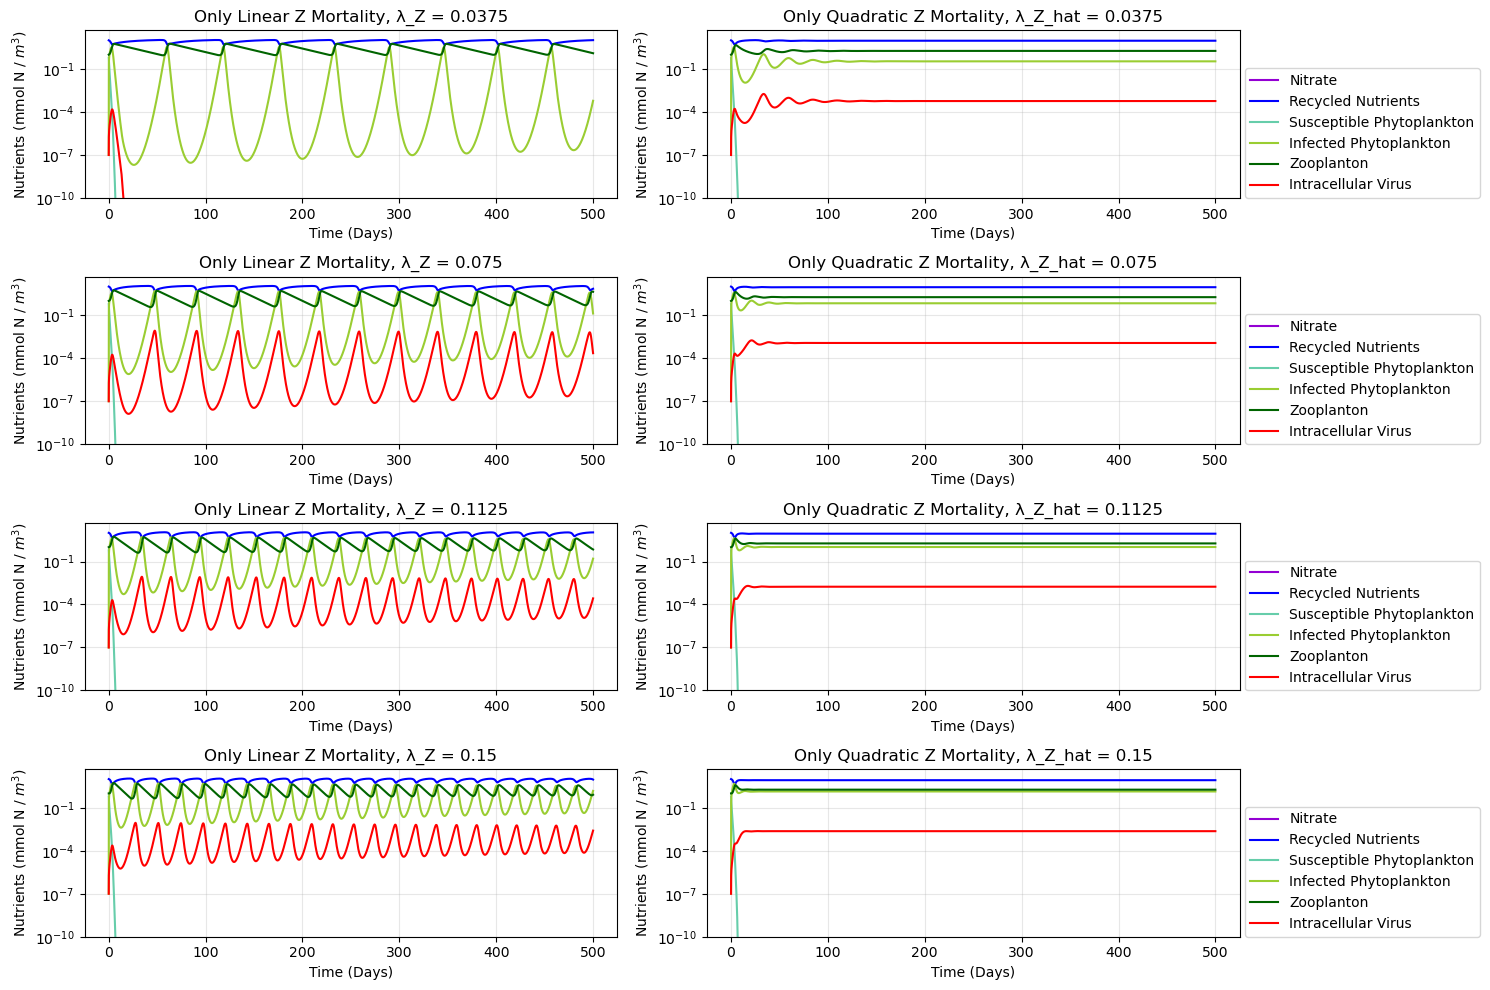

In [51]:
#Plotting VS. comparison

%matplotlib inline

only_lin  = []
only_quad = []

for sol in sols:
    
    lin = sol[0][0]
    quad = sol[0][1]
    
    if lin == 0. and quad != 0.:
        only_quad.append(sol)
        
    elif quad == 0. and lin != 0:
        only_lin.append(sol)
        
fig, axs = plt.subplots(len(only_lin), 2, figsize=(15, 10))

colors = ["darkviolet", "blue", "mediumaquamarine", "yellowgreen", "darkgreen", "red", "darkred"]
labels = ['Nitrate', 'Recycled Nutrients', 'Susceptible Phytoplankton', 'Infected Phytoplankton', 
          'Zooplanton', 'Intracellular Virus', 'Extracellular Virus']

for i in range(len(only_lin)): #Number of different parameterizations
    
    lin, lin_sol = only_lin[i][0][0], only_lin[i][1]
    quad, quad_sol = only_quad[i][0][1], only_quad[i][1]
    
    for k in range(6): #Number of different state variables
        
        #Only Linear
        axs[i][0].plot(lin_sol.t, lin_sol.y[k], color=colors[k], label=labels[k])
        
        #Only Quadratic
        axs[i][1].plot(quad_sol.t, quad_sol.y[k], color=colors[k], label=labels[k])
        
    axs[i][0].set_title(f"Only Linear Z Mortality, λ_Z = {lin:.5}")
    axs[i][1].set_title(f"Only Quadratic Z Mortality, λ_Z_hat = {quad:.5}")
    axs[i][1].legend(loc=(1.01, 0))
    
[[a.set_xlabel("Time (Days)") for a in ax] for ax in axs]
[[a.set_ylabel(r'Nutrients (mmol N / $m^3$)') for a in ax] for ax in axs]
[[a.grid(alpha=.3) for a in ax] for ax in axs]
[[a.set_yscale('log') for a in ax] for ax in axs]
[[a.set_ylim(1e-10, 50) for a in ax] for ax in axs]
    
plt.tight_layout()
plt.show()

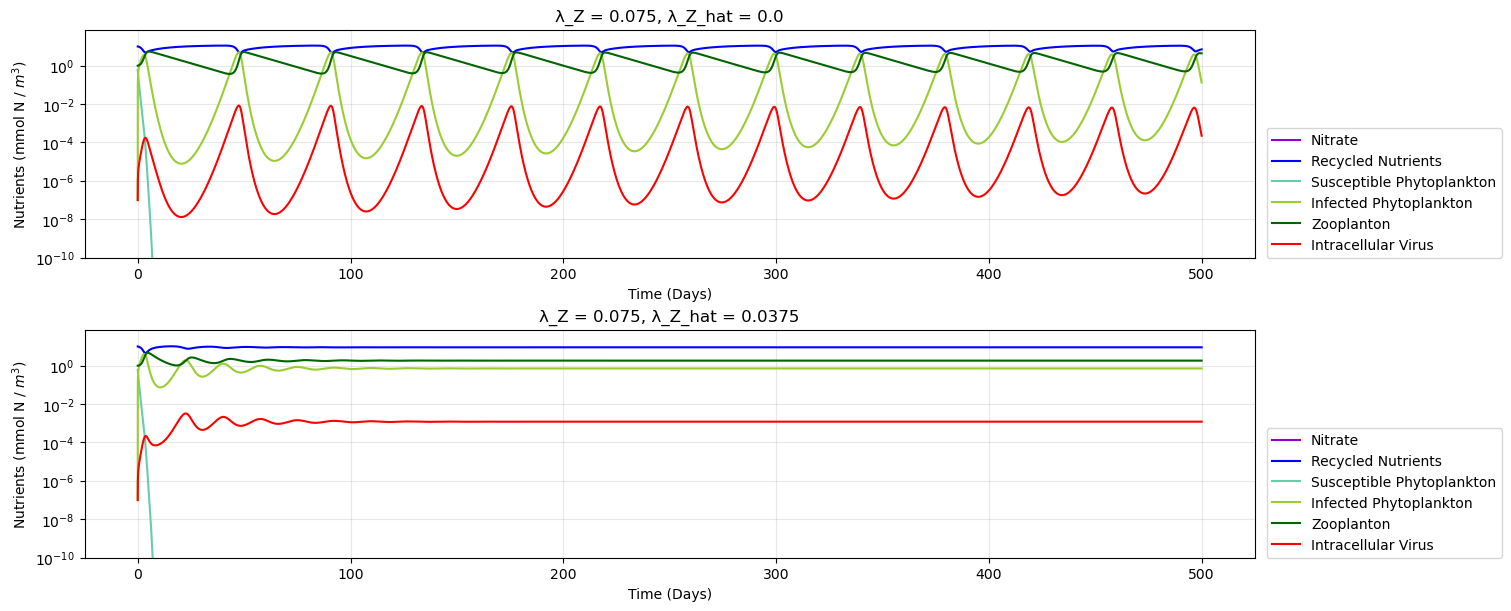

In [60]:
#Plotting *inclusion* of quadratic term with linear

%matplotlib inline

fig, axs = plt.subplots(2, 1, figsize=(15, 6), constrained_layout=True)

colors = ["darkviolet", "blue", "mediumaquamarine", "yellowgreen", "darkgreen", "red", "darkred"]
labels = ['Nitrate', 'Recycled Nutrients', 'Susceptible Phytoplankton', 'Infected Phytoplankton', 
          'Zooplanton', 'Intracellular Virus', 'Extracellular Virus']

count = 0
for combo, sol in sols[10:12]: #Number of different parameterizations
    
    for k in range(6): #Cycle through state variables         
        axs[count].plot(sol.t, sol.y[k], color=colors[k], label=labels[k])
        axs[count].set_title(f"λ_Z = {combo[0]:.5}, λ_Z_hat = {combo[1]:.5}")
    count += 1

[ax.set_xlabel("Time (Days)") for ax in axs]
[ax.set_ylabel(r'Nutrients (mmol N / $m^3$)') for ax in axs]
[ax.grid(alpha=.3) for ax in axs]
[ax.set_yscale('log') for ax in axs]
[ax.set_ylim(1e-10, 75) for ax in axs]
[ax.legend(loc=(1.01, 0)) for ax in axs];

plt.show()